In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/sepsis_Project/Dataset.csv'

df = pd.read_csv(csv_path)
df.head()


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [ ]:
df.columns = df.columns.str.strip()   # remove accidental spaces
print(df.columns.tolist())            # verify


['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID']


In [ ]:
label_col = "SepsisLabel"
id_col = "Patient_ID"
time_col = "Hour"

# find sepsis onset hour for each patient
onset_times = (
    df[df[label_col] == 1]
    .groupby(id_col)[time_col]
    .min()
)

onset_times.head()


,Hour
Patient_ID,
9,248
11,24
15,5
18,125
22,9


In [ ]:
def compute_early_label(row):
    pid = row[id_col]
    hour = row[time_col]

    if pid not in onset_times:  # no sepsis ever
        return 0

    onset = onset_times[pid]
    if (onset - hour <= 6) and (onset - hour > 0):
        return 1
    else:
        return 0

df["EarlyLabel"] = df.apply(compute_early_label, axis=1)
df[["SepsisLabel", "EarlyLabel"]].head(20)


,SepsisLabel,EarlyLabel
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [ ]:
# forward fill per patient
df = df.sort_values([id_col, time_col])
df = df.groupby(id_col).apply(lambda g: g.ffill()).reset_index(drop=True)

# mean fill for remaining NaNs
df = df.fillna(df.mean(numeric_only=True))


/tmp/ipython-input-151808372.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(id_col).apply(lambda g: g.ffill()).reset_index(drop=True)


In [ ]:
time_features = [
    "HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp",
    "EtCO2", "BaseExcess", "HCO3", "FIO2", "pH", "PaCO2", "SaO2",
    "AST", "BUN", "Alkaline", "Calcium", "Chloride", "Creatinine",
    "Glucose", "Lactate", "Magnesi", "Phosph", "Potassium",
    "Hct", "Hgb", "PTT", "WBC", "Platelets", "Fibrinogen"
]

# keep only columns that exist in your dataset
time_features = [f for f in time_features if f in df.columns]

len(time_features), time_features[:10]


(27,
 ['HR',
  'O2Sat',
  'Temp',
  'SBP',
  'MAP',
  'DBP',
  'Resp',
  'EtCO2',
  'BaseExcess',
  'HCO3'])

In [ ]:
import numpy as np

patients = df[id_col].unique()
np.random.seed(42)
np.random.shuffle(patients)

n = len(patients)
train_ids = patients[:int(0.7*n)]
val_ids   = patients[int(0.7*n):int(0.85*n)]
test_ids  = patients[int(0.85*n):]

len(train_ids), len(val_ids), len(test_ids)


(28235, 6050, 6051)

In [ ]:
train_df = df[df[id_col].isin(train_ids)]
mean = train_df[time_features].mean()
std = train_df[time_features].std()

df[time_features] = (df[time_features] - mean) / std


In [ ]:
patient_groups = df.groupby(id_col)

def get_patient_sequence(pid):
    g = patient_groups.get_group(pid).sort_values(time_col)
    X = g[time_features].values            # shape: (T, F)
    y = g["EarlyLabel"].values            # shape: (T,)
    return X, y


In [ ]:
X_sample, y_sample = get_patient_sequence(train_ids[0])
X_sample.shape, y_sample.shape


((26, 27), (26,))

In [ ]:
import numpy as np
import pandas as pd

id_col = "Patient_ID"
time_col = "Hour"
label_col = "EarlyLabel"

# time_features was defined in Phase 2; if not, re-define it like before
time_features = [
    "HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp",
    "EtCO2", "BaseExcess", "HCO3", "FIO2", "pH", "PaCO2", "SaO2",
    "AST", "BUN", "Alkaline", "Calcium", "Chloride", "Creatinine",
    "Glucose", "Lactate", "Magnesi", "Phosph", "Potassium",
    "Hct", "Hgb", "PTT", "WBC", "Platelets", "Fibrinogen"
]

# Keep only existing columns
time_features = [c for c in time_features if c in df.columns]

# Optional static features if present
static_features = [c for c in ["Age", "Gender", "ICULOS"] if c in df.columns]

feature_cols = time_features + static_features
print("Num features:", len(feature_cols))
feature_cols


Num features: 30


['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Potassium',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Platelets',
 'Fibrinogen',
 'Age',
 'Gender',
 'ICULOS']

In [ ]:
patients = df[id_col].unique()
np.random.seed(42)
np.random.shuffle(patients)

n = len(patients)
train_ids = patients[:int(0.7*n)]
val_ids   = patients[int(0.7*n):int(0.85*n)]
test_ids  = patients[int(0.85*n):]

len(train_ids), len(val_ids), len(test_ids)


(28235, 6050, 6051)

In [ ]:
train_df = df[df[id_col].isin(train_ids)]
val_df   = df[df[id_col].isin(val_ids)]
test_df  = df[df[id_col].isin(test_ids)]

for name, d in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(name, d.shape, "positives:", d[label_col].sum())


train (1085255, 45) positives: 9962
val (230301, 45) positives: 1937
test (236654, 45) positives: 2180


In [ ]:
X_train = train_df[feature_cols].values
y_train = train_df[label_col].values

X_val = val_df[feature_cols].values
y_val = val_df[label_col].values

X_test = test_df[feature_cols].values
y_test = test_df[label_col].values

X_train.shape, X_val.shape, X_test.shape


((1085255, 30), (230301, 30), (236654, 30))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

# Predictions
val_probs = log_reg.predict_proba(X_val)[:, 1]
test_probs = log_reg.predict_proba(X_test)[:, 1]

val_auc = roc_auc_score(y_val, val_probs)
val_auprc = average_precision_score(y_val, val_probs)

test_auc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)

print(f"LogReg - VAL  AUROC: {val_auc:.3f}, AUPRC: {val_auprc:.3f}")
print(f"LogReg - TEST AUROC: {test_auc:.3f}, AUPRC: {test_auprc:.3f}")


LogReg - VAL  AUROC: 0.722, AUPRC: 0.034
LogReg - TEST AUROC: 0.737, AUPRC: 0.040


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

rf.fit(X_train, y_train)

val_probs_rf = rf.predict_proba(X_val)[:, 1]
test_probs_rf = rf.predict_proba(X_test)[:, 1]

val_auc_rf = roc_auc_score(y_val, val_probs_rf)
val_auprc_rf = average_precision_score(y_val, val_probs_rf)

test_auc_rf = roc_auc_score(y_test, test_probs_rf)
test_auprc_rf = average_precision_score(y_test, test_probs_rf)

print(f"RF - VAL  AUROC: {val_auc_rf:.3f}, AUPRC: {val_auprc_rf:.3f}")
print(f"RF - TEST AUROC: {test_auc_rf:.3f}, AUPRC: {test_auprc_rf:.3f}")


RF - VAL  AUROC: 0.737, AUPRC: 0.023
RF - TEST AUROC: 0.757, AUPRC: 0.028


In [ ]:
results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Val_AUROC": val_auc,
        "Val_AUPRC": val_auprc,
        "Test_AUROC": test_auc,
        "Test_AUPRC": test_auprc,
    },
    {
        "Model": "Random Forest",
        "Val_AUROC": val_auc_rf,
        "Val_AUPRC": val_auprc_rf,
        "Test_AUROC": test_auc_rf,
        "Test_AUPRC": test_auprc_rf,
    },
])

results


,Model,Val_AUROC,Val_AUPRC,Test_AUROC,Test_AUPRC
0,Logistic Regression,0.721771,0.033884,0.736723,0.039867
1,Random Forest,0.737218,0.023345,0.757491,0.027609


In [ ]:
import numpy as np

id_col = "Patient_ID"
time_col = "Hour"
label_col = "EarlyLabel"

# if you lost these, re-create them as in Phase 2
patients = df[id_col].unique()
np.random.seed(42)
np.random.shuffle(patients)

n = len(patients)
train_ids = patients[:int(0.7*n)]
val_ids   = patients[int(0.7*n):int(0.85*n)]
test_ids  = patients[int(0.85*n):]

# feature list (make sure it matches your df)
time_features = [c for c in [
    "HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp",
    "EtCO2", "BaseExcess", "HCO3", "FIO2", "pH", "PaCO2", "SaO2",
    "AST", "BUN", "Alkaline", "Calcium", "Chloride", "Creatinine",
    "Glucose", "Lactate", "Magnesi", "Phosph", "Potassium",
    "Hct", "Hgb", "PTT", "WBC", "Platelets", "Fibrinogen"
] if c in df.columns]

print("Using", len(time_features), "features.")


Using 27 features.


In [ ]:
# sort once
df = df.sort_values([id_col, time_col])
groups = df.groupby(id_col)

def get_sequence(pid):
    g = groups.get_group(pid)
    X = g[time_features].values.astype("float32")   # (T, F)
    y = g[label_col].values.astype("float32")       # (T,)
    return X, y

# build lists of sequences for each split
train_seqs = [get_sequence(pid) for pid in train_ids]
val_seqs   = [get_sequence(pid) for pid in val_ids]
test_seqs  = [get_sequence(pid) for pid in test_ids]

len(train_seqs), len(val_seqs), len(test_seqs)


(28235, 6050, 6051)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
class SepsisSeqDataset(Dataset):
    def __init__(self, sequences):
        # sequences = list of (X, y) where
        # X: (T, F), y: (T,)
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        X = torch.from_numpy(X)        # (T, F)
        y = torch.from_numpy(y)        # (T,)
        return X, y


In [ ]:
def collate_batch(batch):
    # batch: list of (X, y) tensors, variable lengths
    xs, ys = zip(*batch)   # lists of tensors

    lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)

    # pad to max length in batch
    max_len = max(lengths).item()
    feat_dim = xs[0].shape[1]

    X_padded = torch.zeros(len(xs), max_len, feat_dim, dtype=torch.float32)
    y_padded = torch.zeros(len(xs), max_len, dtype=torch.float32)
    mask = torch.zeros(len(xs), max_len, dtype=torch.float32)

    for i, (x, y) in enumerate(zip(xs, ys)):
        l = x.shape[0]
        X_padded[i, :l, :] = x
        y_padded[i, :l] = y
        mask[i, :l] = 1.0   # 1 for real timesteps, 0 for padding

    return X_padded, y_padded, lengths, mask


In [ ]:
batch_size = 32

train_dataset = SepsisSeqDataset(train_seqs)
val_dataset   = SepsisSeqDataset(val_seqs)
test_dataset  = SepsisSeqDataset(test_seqs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_batch)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          collate_fn=collate_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          collate_fn=collate_batch)


In [ ]:
import torch.nn as nn

class LSTMEarlySepsis(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1,
                 bidirectional=True, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * num_directions, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)        # (batch, seq_len, hidden*D)
        logits = self.fc(out).squeeze(-1)  # (batch, seq_len)
        return logits


In [ ]:
input_size = len(time_features)
model = LSTMEarlySepsis(input_size=input_size, hidden_size=128,
                        num_layers=1, bidirectional=True, dropout=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss(reduction="none")  # we will mask manually
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import math


In [ ]:
def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_steps = 0

    all_targets = []
    all_probs = []

    for X, y, lengths, mask in loader:
        X = X.to(device)
        y = y.to(device)
        mask = mask.to(device)

        with torch.set_grad_enabled(train):
            logits = model(X)  # (B, T)
            loss_raw = criterion(logits, y)  # (B, T)

            # apply mask
            loss_masked = loss_raw * mask
            # average over actual (non-padded) positions
            loss = loss_masked.sum() / mask.sum().clamp_min(1.0)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * mask.sum().item()
        total_steps += mask.sum().item()

        # collect for metrics
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        targets = y.detach().cpu().numpy()
        m = mask.detach().cpu().numpy()

        # flatten only valid positions
        all_probs.append(probs[m == 1])
        all_targets.append(targets[m == 1])

    avg_loss = total_loss / total_steps if total_steps > 0 else math.nan
    all_probs = np.concatenate(all_probs) if len(all_probs) > 0 else np.array([])
    all_targets = np.concatenate(all_targets) if len(all_targets) > 0 else np.array([])

    if len(np.unique(all_targets)) > 1:
        auroc = roc_auc_score(all_targets, all_probs)
        auprc = average_precision_score(all_targets, all_probs)
    else:
        auroc, auprc = math.nan, math.nan

    return avg_loss, auroc, auprc


In [ ]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss, train_auc, train_auprc = run_epoch(model, train_loader, train=True)
    val_loss, val_auc, val_auprc = run_epoch(model, val_loader, train=False)

    print(f"Epoch {epoch:02d}:")
    print(f"  Train - Loss: {train_loss:.4f}, AUROC: {train_auc:.3f}, AUPRC: {train_auprc:.3f}")
    print(f"  Val   - Loss: {val_loss:.4f}, AUROC: {val_auc:.3f}, AUPRC: {val_auprc:.3f}")


Epoch 01:
  Train - Loss: 0.0605, AUROC: 0.661, AUPRC: 0.017
  Val   - Loss: 0.0464, AUROC: 0.722, AUPRC: 0.027
Epoch 02:
  Train - Loss: 0.0471, AUROC: 0.761, AUPRC: 0.051
  Val   - Loss: 0.0419, AUROC: 0.794, AUPRC: 0.106
Epoch 03:
  Train - Loss: 0.0399, AUROC: 0.862, AUPRC: 0.180
  Val   - Loss: 0.0396, AUROC: 0.848, AUPRC: 0.169
Epoch 04:
  Train - Loss: 0.0325, AUROC: 0.939, AUPRC: 0.295
  Val   - Loss: 0.0292, AUROC: 0.954, AUPRC: 0.291
Epoch 05:
  Train - Loss: 0.0283, AUROC: 0.965, AUPRC: 0.378
  Val   - Loss: 0.0276, AUROC: 0.965, AUPRC: 0.313


In [ ]:
test_loss, test_auc, test_auprc = run_epoch(model, test_loader, train=False)
print(f"TEST - Loss: {test_loss:.4f}, AUROC: {test_auc:.3f}, AUPRC: {test_auprc:.3f}")


TEST - Loss: 0.0280, AUROC: 0.971, AUPRC: 0.384


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import torch


In [ ]:
def get_predictions(model, loader):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for X, y, lengths, mask in loader:
            X = X.to(device)
            y = y.to(device)
            mask = mask.to(device)

            logits = model(X)                    # (B, T)
            probs = torch.sigmoid(logits)        # probabilities

            probs = probs.cpu().numpy()
            y = y.cpu().numpy()
            m = mask.cpu().numpy()

            # Keep only VALID timesteps (mask==1)
            all_probs.append(probs[m == 1])
            all_targets.append(y[m == 1])

    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    return all_targets, all_probs


In [ ]:
train_y, train_p = get_predictions(model, train_loader)
val_y, val_p     = get_predictions(model, val_loader)
test_y, test_p   = get_predictions(model, test_loader)


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

results = {
    "Train_AUROC": roc_auc_score(train_y, train_p),
    "Train_AUPRC": average_precision_score(train_y, train_p),
    "Val_AUROC": roc_auc_score(val_y, val_p),
    "Val_AUPRC": average_precision_score(val_y, val_p),
    "Test_AUROC": roc_auc_score(test_y, test_p),
    "Test_AUPRC": average_precision_score(test_y, test_p)
}

results


{'Train_AUROC': np.float64(0.9760170310970069),
 'Train_AUPRC': np.float64(0.442407802878672),
 'Val_AUROC': np.float64(0.9651458080306484),
 'Val_AUPRC': np.float64(0.3129241241123844),
 'Test_AUROC': np.float64(0.971012413653109),
 'Test_AUPRC': np.float64(0.3844409009999763)}

In [ ]:
def plot_roc(y, p, title):
    fpr, tpr, _ = roc_curve(y, p)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
def plot_pr(y, p, title):
    precision, recall, _ = precision_recall_curve(y, p)
    auprc = average_precision_score(y, p)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AUPRC = {auprc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


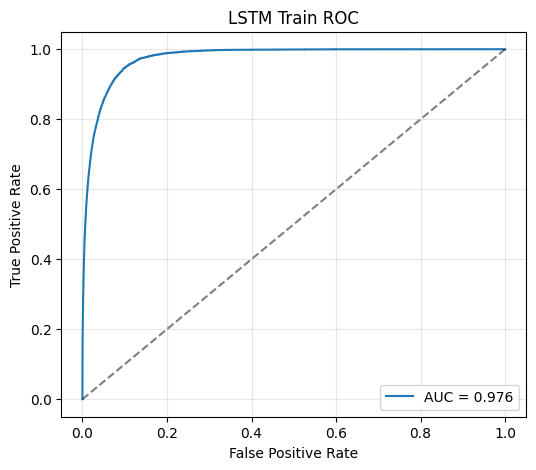

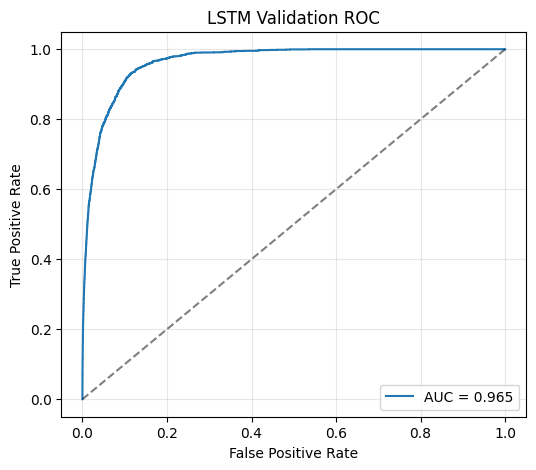

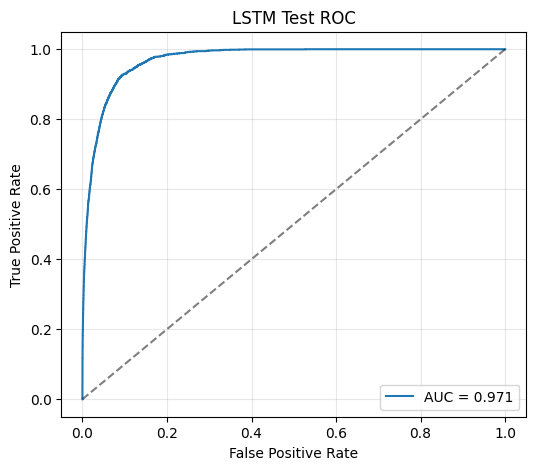

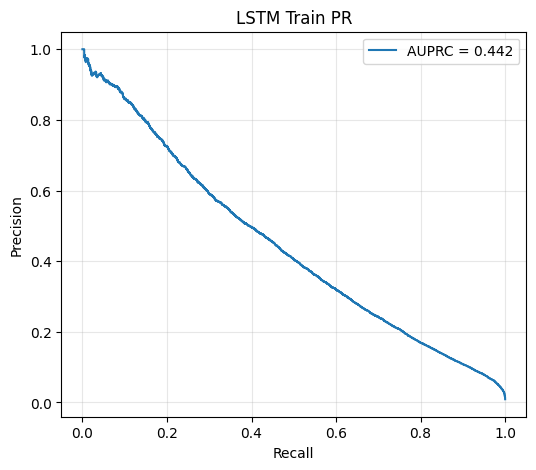

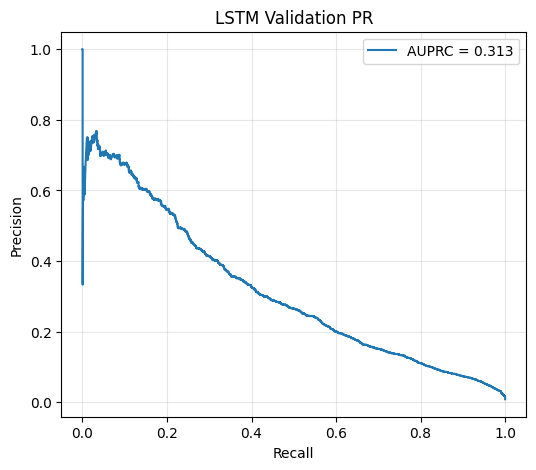

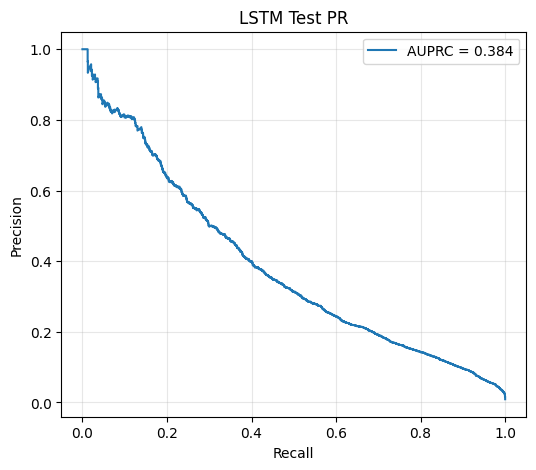

In [ ]:
# ROC curves
plot_roc(train_y, train_p, "LSTM Train ROC")
plot_roc(val_y, val_p, "LSTM Validation ROC")
plot_roc(test_y, test_p, "LSTM Test ROC")

# PR curves
plot_pr(train_y, train_p, "LSTM Train PR")
plot_pr(val_y, val_p, "LSTM Validation PR")
plot_pr(test_y, test_p, "LSTM Test PR")


In [ ]:
import json

save_path = "/content/drive/MyDrive/sepsis_Project/lstm_results.json"
with open(save_path, "w") as f:
    json.dump(results, f, indent=4)

print("Saved to:", save_path)


Saved to: /content/drive/MyDrive/sepsis_Project/lstm_results.json


In [ ]:
import torch
import torch.nn as nn

class LSTMEarlySepsisWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1,
                 bidirectional=True, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        num_directions = 2 if bidirectional else 1
        self.h_dim = hidden_size * num_directions

        # attention: score_t = v^T tanh(W h_t)
        self.attn_W = nn.Linear(self.h_dim, self.h_dim)
        self.attn_v = nn.Linear(self.h_dim, 1, bias=False)

        # sequence-level classifier
        self.fc_seq = nn.Linear(self.h_dim, 1)

        # optional per-timestep classifier (like your old LSTM)
        self.fc_timestep = nn.Linear(self.h_dim, 1)

    def forward(self, x, mask=None, return_all=False):
        """
        x: (B, T, F)
        mask: (B, T) with 1 for real steps, 0 for padding (optional but recommended)
        return_all: if True, also return per-timestep logits
        """
        out, _ = self.lstm(x)  # out: (B, T, H)

        # attention scores
        u = torch.tanh(self.attn_W(out))       # (B, T, H)
        scores = self.attn_v(u).squeeze(-1)    # (B, T)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)  # ignore pads

        # attention weights
        attn_weights = torch.softmax(scores, dim=1)       # (B, T)

        # context vector: weighted sum of hidden states
        context = torch.bmm(attn_weights.unsqueeze(1), out).squeeze(1)  # (B, H)

        # sequence-level logit
        seq_logit = self.fc_seq(context).squeeze(-1)      # (B,)

        if return_all:
            # per-timestep logits too
            ts_logits = self.fc_timestep(out).squeeze(-1)  # (B, T)
            return seq_logit, attn_weights, ts_logits

        return seq_logit, attn_weights


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class SepsisSeqDatasetSeqLabel(Dataset):
    def __init__(self, sequences):
        # sequences: list of (X, y_timestep)
        self.Xs = []
        self.ys_seq = []
        for X, y in sequences:
            self.Xs.append(torch.from_numpy(X.astype("float32")))
            # sequence label: any timestep is positive?
            self.ys_seq.append(float((y > 0.5).any()))

    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx], torch.tensor(self.ys_seq[idx], dtype=torch.float32)

def collate_batch_seqlabel(batch):
    xs, ys_seq = zip(*batch)
    lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)
    max_len = max(lengths).item()
    feat_dim = xs[0].shape[1]

    X_padded = torch.zeros(len(xs), max_len, feat_dim, dtype=torch.float32)
    mask = torch.zeros(len(xs), max_len, dtype=torch.float32)

    for i, x in enumerate(xs):
        l = x.shape[0]
        X_padded[i, :l, :] = x
        mask[i, :l] = 1.0

    ys_seq = torch.stack(ys_seq)  # (B,)
    return X_padded, ys_seq, lengths, mask


In [ ]:
batch_size = 32

train_dataset_attn = SepsisSeqDatasetSeqLabel(train_seqs)
val_dataset_attn   = SepsisSeqDatasetSeqLabel(val_seqs)
test_dataset_attn  = SepsisSeqDatasetSeqLabel(test_seqs)

train_loader_attn = DataLoader(
    train_dataset_attn, batch_size=batch_size, shuffle=True,
    collate_fn=collate_batch_seqlabel
)
val_loader_attn = DataLoader(
    val_dataset_attn, batch_size=batch_size, shuffle=False,
    collate_fn=collate_batch_seqlabel
)
test_loader_attn = DataLoader(
    test_dataset_attn, batch_size=batch_size, shuffle=False,
    collate_fn=collate_batch_seqlabel
)


In [ ]:
input_size = len(time_features)
model_attn = LSTMEarlySepsisWithAttention(
    input_size=input_size, hidden_size=128,
    num_layers=1, bidirectional=True, dropout=0.1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_attn = model_attn.to(device)

criterion_seq = nn.BCEWithLogitsLoss()
optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=1e-3)


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
import math

def run_epoch_seq(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_samples = 0
    all_targets = []
    all_probs = []

    for X, y_seq, lengths, mask in loader:
        X = X.to(device)
        y_seq = y_seq.to(device)
        mask = mask.to(device)

        with torch.set_grad_enabled(train):
            logits, attn = model(X, mask=mask)  # (B,), (B,T)
            loss = criterion_seq(logits, y_seq)

            if train:
                optimizer_attn.zero_grad()
                loss.backward()
                optimizer_attn.step()

        bs = X.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        targets = y_seq.detach().cpu().numpy()
        all_probs.append(probs)
        all_targets.append(targets)

    avg_loss = total_loss / total_samples if total_samples > 0 else math.nan
    all_probs = np.concatenate(all_probs) if len(all_probs) > 0 else np.array([])
    all_targets = np.concatenate(all_targets) if len(all_targets) > 0 else np.array([])

    if len(np.unique(all_targets)) > 1:
        auroc = roc_auc_score(all_targets, all_probs)
        auprc = average_precision_score(all_targets, all_probs)
    else:
        auroc, auprc = math.nan, math.nan

    return avg_loss, auroc, auprc

num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss, train_auc, train_auprc = run_epoch_seq(model_attn, train_loader_attn, train=True)
    val_loss, val_auc, val_auprc = run_epoch_seq(model_attn, val_loader_attn, train=False)

    print(f"Epoch {epoch:02d}:")
    print(f"  Train - Loss: {train_loss:.4f}, AUROC: {train_auc:.3f}, AUPRC: {train_auprc:.3f}")
    print(f"  Val   - Loss: {val_loss:.4f}, AUROC: {val_auc:.3f}, AUPRC: {val_auprc:.3f}")


Epoch 01:
  Train - Loss: 0.2093, AUROC: 0.752, AUPRC: 0.220
  Val   - Loss: 0.1796, AUROC: 0.802, AUPRC: 0.301
Epoch 02:
  Train - Loss: 0.1863, AUROC: 0.814, AUPRC: 0.345
  Val   - Loss: 0.1736, AUROC: 0.812, AUPRC: 0.349
Epoch 03:
  Train - Loss: 0.1797, AUROC: 0.832, AUPRC: 0.380
  Val   - Loss: 0.1690, AUROC: 0.832, AUPRC: 0.360
Epoch 04:
  Train - Loss: 0.1719, AUROC: 0.854, AUPRC: 0.420
  Val   - Loss: 0.1707, AUROC: 0.839, AUPRC: 0.345
Epoch 05:
  Train - Loss: 0.1666, AUROC: 0.869, AUPRC: 0.439
  Val   - Loss: 0.1733, AUROC: 0.821, AUPRC: 0.320


In [ ]:
test_loss, test_auc, test_auprc = run_epoch_seq(model_attn, test_loader_attn, train=False)
print(f"TEST - Loss: {test_loss:.4f}, AUROC: {test_auc:.3f}, AUPRC: {test_auprc:.3f}")


TEST - Loss: 0.1788, AUROC: 0.837, AUPRC: 0.396


In [ ]:
# pick a septic patient from test set
septic_test_indices = [
    i for i, (X, y_seq) in enumerate(test_dataset_attn)
    if y_seq.item() == 1.0
]

print("Number of septic test sequences:", len(septic_test_indices))
example_idx = septic_test_indices[0]


Number of septic test sequences: 383


In [ ]:
X_example, y_example = test_dataset_attn[example_idx]
X_example = X_example.unsqueeze(0).to(device)   # add batch dim
length = X_example.shape[1]
mask_example = torch.ones(1, length, dtype=torch.float32).to(device)

model_attn.eval()
with torch.no_grad():
    logit, attn_weights = model_attn(X_example, mask=mask_example)
    prob = torch.sigmoid(logit).item()
    attn_weights = attn_weights.squeeze(0).cpu().numpy()  # (T,)

print("Sequence-level label (y):", y_example.item())
print("Predicted risk:", prob)
print("Attention shape:", attn_weights.shape)


Sequence-level label (y): 1.0
Predicted risk: 0.3793203830718994
Attention shape: (20,)


In [ ]:
# we need to know which Patient_ID this example corresponds to:
# test_seqs is in same order as test_ids

# helper: rebuild mapping from index to patient id
test_pid_to_idx = {i: pid for i, pid in enumerate(test_ids)}
example_pid = test_pid_to_idx[example_idx] if example_idx < len(test_ids) else None
example_pid


np.int64(107375)

In [ ]:
# pick a specific known septic patient from df instead:
septic_pids = df[df["EarlyLabel"] == 1]["Patient_ID"].unique()
example_pid = septic_pids[0]
g = df[df["Patient_ID"] == example_pid].sort_values("Hour")

hours = g["Hour"].values
early_labels = g["EarlyLabel"].values
# if SepsisLabel exists:
if "SepsisLabel" in g.columns:
    sepsis_labels = g["SepsisLabel"].values
else:
    sepsis_labels = None

X_example = g[time_features].values.astype("float32")
T = X_example.shape[0]
X_tensor = torch.from_numpy(X_example).unsqueeze(0).to(device)
mask_tensor = torch.ones(1, T, dtype=torch.float32).to(device)

model_attn.eval()
with torch.no_grad():
    logit, attn_weights = model_attn(X_tensor, mask=mask_tensor)
    prob = torch.sigmoid(logit).item()
    attn_weights = attn_weights.squeeze(0).cpu().numpy()

print("Example Patient_ID:", example_pid)
print("Predicted seq risk:", prob)
print("Sequence length:", T)


Example Patient_ID: 9
Predicted seq risk: 0.5971580147743225
Sequence length: 258


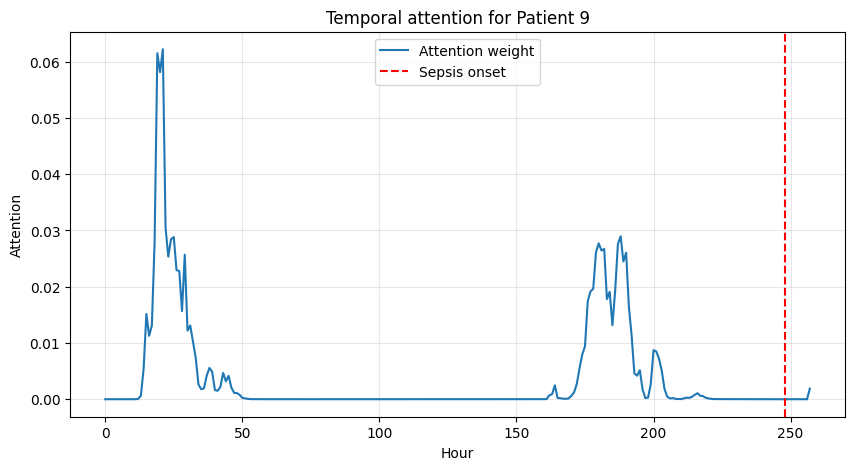

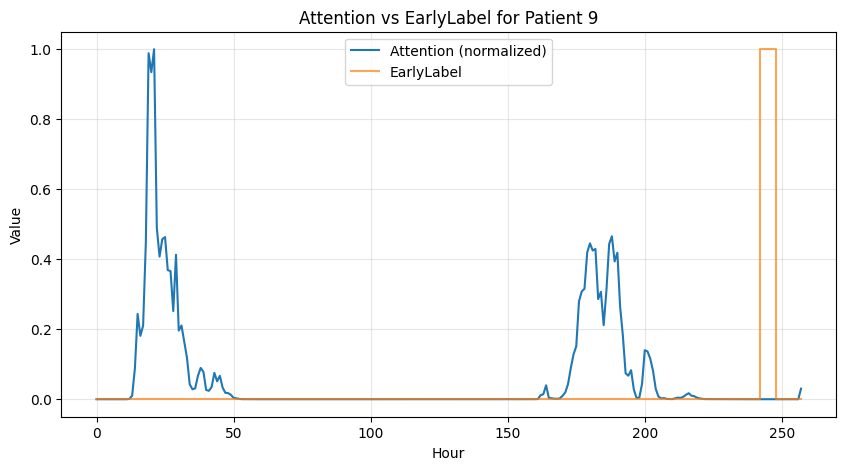

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(hours, attn_weights, label="Attention weight")
plt.xlabel("Hour")
plt.ylabel("Attention")
plt.title(f"Temporal attention for Patient {example_pid}")
plt.grid(alpha=0.3)

if sepsis_labels is not None:
    onset_hour = hours[sepsis_labels.argmax()] if sepsis_labels.max() > 0 else None
    if onset_hour is not None:
        plt.axvline(onset_hour, color="red", linestyle="--", label="Sepsis onset")

plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(hours, attn_weights / attn_weights.max(), label="Attention (normalized)")
plt.step(hours, early_labels, where="post", label="EarlyLabel", alpha=0.7)
plt.xlabel("Hour")
plt.ylabel("Value")
plt.title(f"Attention vs EarlyLabel for Patient {example_pid}")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
